In [1]:
import numpy as np
np.random.seed(12345)
from scipy.special import erfinv
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('./hda.mplstyle')
plt.rcParams["text.usetex"] = False
%matplotlib inline

from itertools import product
from tqdm import tqdm

## (Empirische) Data

In [2]:
mnl = pd.read_excel('mnl.xlsx', header=None, names=('text', 'witness'))
mnl.head(10)

,text,witness
0,Aiol (1),H1
1,Aiol (2),H2
2,Alexanders Geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
3,Alexanders Geesten,H3
4,Alexanders Geesten,H4
5,Alexanders Geesten,H5
6,Alexanders Geesten,H6
7,Arturs doet,"Den Haag, KB, 129 A 10"
8,Arturs doet,"Rijksarchief te Antwerpen, Sint-Catharinakapit..."
9,Aubri de Borgengoen,H7


In [3]:
mnl.groupby('text').size().sort_values(ascending=False).values

array([16, 10, 10,  7,  6,  5,  5,  5,  4,  4,  4,  3,  3,  3,  3,  3,  3,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

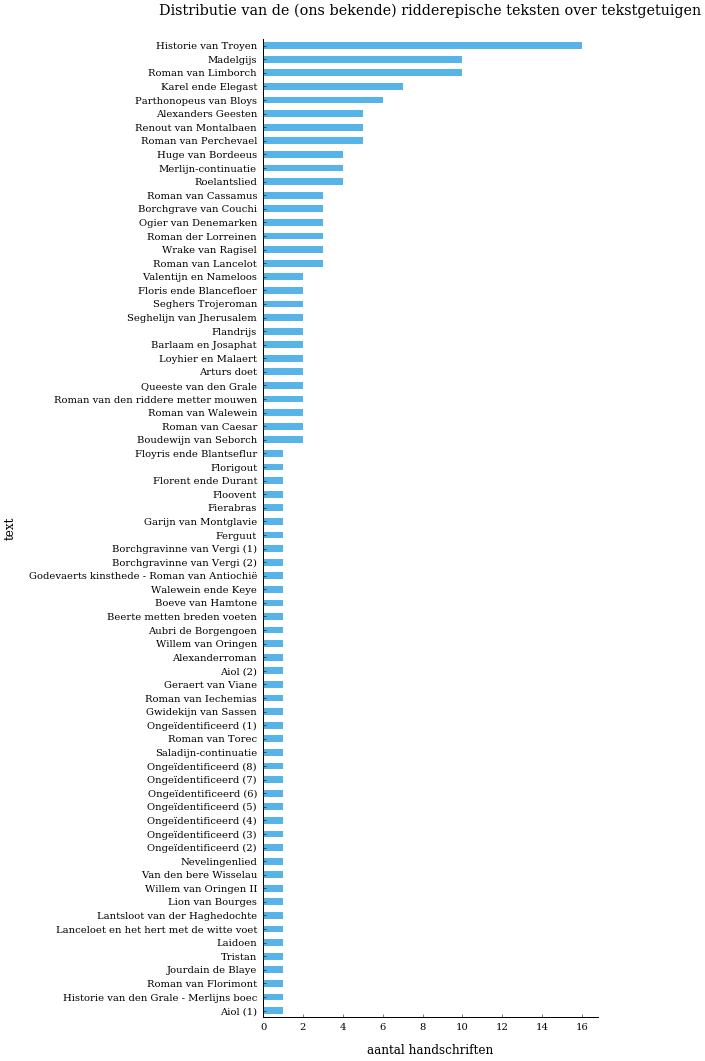

In [4]:
plt.figure(figsize=(6,18))
mnl.groupby('text').size().sort_values(ascending=True).plot.barh(ax=plt.gca());
plt.xlabel('unieke teksten')
plt.xlabel('aantal handschriften')
plt.title('Distributie van de (ons bekende) ridderepische teksten over tekstgetuigen')
plt.savefig('histogram.tiff')

In [5]:
def species_richness(counts):
    return np.sum(counts > 0)

print('# unieke teksten:', species_richness(mnl.groupby('text').size()))
print('# unieke handschriften:', len(mnl))
print('ratio:', len(mnl) / species_richness(mnl.groupby('text').size()))

# unieke teksten: 72
# unieke handschriften: 162
ratio: 2.25


Een alternatief perspectief op de distributie:

In [6]:
types = mnl.groupby('text').size().sort_values(ascending=False).value_counts().sort_index()
types = types.to_frame(name='aantal teksten')
types['aantal handschriften'] = types.index

from IPython.display import display, HTML
display(HTML(types.to_html(index=False)))

aantal teksten,aantal handschriften
42,1
13,2
6,3
3,4
3,5
1,6
1,7
2,10
1,16


## Jackknife

We willen dus de bias in deze dataset dus berekenen en gebruik om bepaalde tellingen, zoals het aantal soorten, op een verantwoord manier naar boven bij te stellen. Een eenvoudige, op dit moment al ietwat verouderde methode is de zogenaamde *first-order jackknife*, het 'knipmes van de eerste orde'. We itereren over alle handschriften en laten telkens één tekstgetuige weg, waarna we opnieuw de soortenrijkdom in de iets verkleinde dataset berekenen. Vervolgens nemen we gemiddelde van de verkregen waarden en we berekenen hoe ver we van de rijkdom van de volledige set verwijderd waren. Deze bias kan vervolgens verrekend worden door deze af te trekken van de oncorrigeerde soortenrijkdom:

In [7]:
def jackknife(data, conf_lvl = .95):
    jack_stat = species_richness(data)
    
    x = np.array(sum([[i]*c for i, c in enumerate(data, 1)], []))
    index = np.arange(x.shape[0])
    
    vals = []
    for i in range(x.shape[0]):
        t = x[index != i]
        vals.append(species_richness(np.bincount(t)))
    
    mean_jack_stat = np.mean(vals)
    bias = (x.shape[0]-1) * (mean_jack_stat - jack_stat)
    
    estimate = jack_stat - bias
    
    std_err = np.sqrt((x.shape[0] - 1) * np.mean((mean_jack_stat - vals) * (mean_jack_stat - vals), axis=0))    
    
    z_score = np.sqrt(2.0) * erfinv(conf_lvl)
    conf_interval = estimate + z_score * np.array((-std_err, std_err))
    
    return estimate, std_err, conf_interval

results = jackknife(mnl.groupby('text').size())
print('jackknife-estimate (order=1):', results)

jackknife-estimate (order=1): (113.74074074073964, 5.560491634321871, array([102.8423774 , 124.63910408]))


Deze berekening is ook vrij eenvoudig analytisch uit te voeren:

In [8]:
num_per_text = mnl.groupby('text').size()

Het totale aantal unieke teksten is *t*:

In [9]:
t = species_richness(num_per_text)
t

72

Het aantal teksten dat slechts één keer voorkomt is *s*:

In [10]:
s = sum(num_per_text == 1)
s

42

Gemiddeld bekomen we dus deze afwijking:

In [11]:
mu = (((t - s) * t) + (s * (t - 1))) / t
mu

71.41666666666667

Zodat we de bias als volgt kunnen vaststellen:

In [12]:
bias = (t - 1) * (mu - t)
bias

-41.41666666666633

In [13]:
(t - 1) * ((((t - s) * t) + (s * (t - 1))) / t - t)

-41.41666666666633

En als volgt kunnen we dit verrekenen:

In [14]:
t - bias

113.41666666666633

## Eenvoudig voorbeeld

In [15]:
counts = [5, 4, 3, 3, 1, 1, 1, 1, 1]
names = 'ABCDEFGHI'
data = zip(counts, names)
df = pd.DataFrame(zip(names, counts), columns=('naam', 'mss'))

display(HTML(df.to_html(index=False)))

naam,mss
A,5
B,4
C,3
D,3
E,1
F,1
G,1
H,1
I,1


In [16]:
print('totaal # handschriften:', df['mss'].sum())

totaal # handschriften: 20


In [17]:
species_richness(df['mss'])

9

Wat me moeten bekomen:

In [18]:
jackknife(df['mss'])

(13.75, 1.8874586088176875, array([10.0506491, 17.4493509]))

In [19]:
data = np.array(df['mss'])
x = np.array(sum([[i]*c for i, c in enumerate(data, 1)], []))
tradition = [names[i - 1] for i in x]
print(tradition)

['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'D', 'D', 'D', 'E', 'F', 'G', 'H', 'I']


In [20]:
bootstrap = []
for i in range(len(tradition)):
    tradition_ = [tradition[j] for j in range(len(tradition)) if i != j]
    
    bootstrap.append((
        (i + 1), tradition[i], ''.join(tradition_),
        len(set(tradition_)), len(set(tradition_)) - len(set(tradition))))

In [21]:
df = pd.DataFrame(bootstrap, columns=('iteration', 'leftout', 'imputed tradition', 'richness', 'error'))
display(HTML(df.to_html(index=False)))

iteration,leftout,imputed tradition,richness,error
1,A,AAAABBBBCCCDDDEFGHI,9,0
2,A,AAAABBBBCCCDDDEFGHI,9,0
3,A,AAAABBBBCCCDDDEFGHI,9,0
4,A,AAAABBBBCCCDDDEFGHI,9,0
5,A,AAAABBBBCCCDDDEFGHI,9,0
6,B,AAAAABBBCCCDDDEFGHI,9,0
7,B,AAAAABBBCCCDDDEFGHI,9,0
8,B,AAAAABBBCCCDDDEFGHI,9,0
9,B,AAAAABBBCCCDDDEFGHI,9,0
10,C,AAAAABBBBCCDDDEFGHI,9,0


In [22]:
mean_estimate = np.mean(df['richness'])
print('gemiddelde schatting:', mean_estimate)
print('afwijking:', mean_estimate - 9)

gemiddelde schatting: 8.75
afwijking: -0.25


In [23]:
bias = 19 * (mean_estimate - 9)
bias

-4.75

In [24]:
corrected = 9 - bias
corrected

13.75

In [25]:
conf_lvl = .95

std_err = np.sqrt(19 * np.mean((mean_estimate - df['richness']) * (mean_estimate - df['richness']), axis=0))    
    
z_score = np.sqrt(2.0) * erfinv(conf_lvl)
conf_interval = corrected + z_score * np.array((-std_err, std_err))
conf_interval

array([10.0506491, 17.4493509])

## Chao

Basisformule, gebaseerd op 1-tjes en 2-tjes:

In [26]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

Levert al een hogere, waarschijnlijk meer realistische, schatting op -- hoewel dit nog steeds een theoretische ondergrens is voor het reële tekstverlies.

In [27]:
chao_richness(num_per_text)

139.4273504273504

Monsteringsproces om variantie in kaart te brengen:

In [28]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([fn(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

In [29]:
def chao_estimate(x, n_iter=1000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [30]:
lci_pro, uci_pro, bt_pro, pro = chao_estimate(num_per_text, n_iter=10000)
print('pro:', pro)
print('lci_pro:', lci_pro)
print('uci_pro:', uci_pro)

pro: 139.4273504273504
lci_pro: 100.93406431831897
uci_pro: 204.7979109958787


In [31]:
bt_pro

array([128.88109087, 128.03373752, 116.83875976, ..., 161.0638755 ,
       111.66313476, 160.10747118])

In [32]:
import ptitprince as pt
import seaborn as sns

d = list([(x, 'bt') for x in bt_pro])
bt = pd.DataFrame(d, columns=('bt', 'type'))

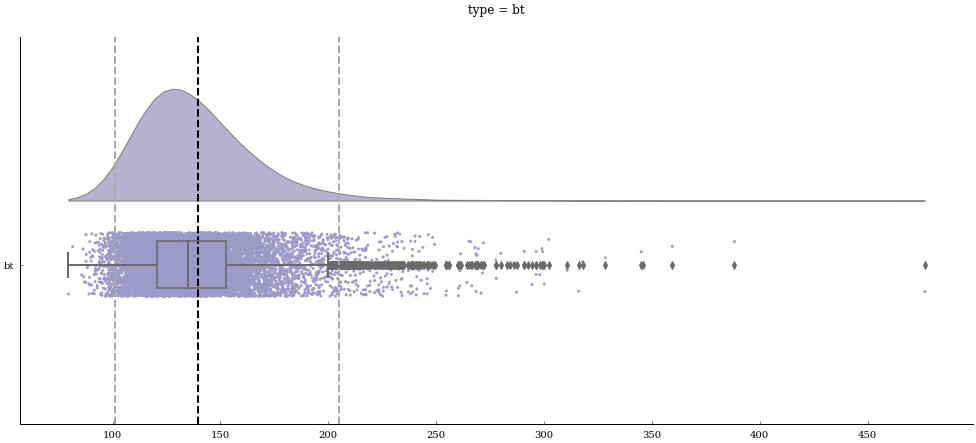

In [33]:
g = sns.FacetGrid(bt, col="type", sharey=False, aspect=1.5)
g = g.map_dataframe(pt.RainCloud, x="type", y="bt", data=bt, palette='Purples',
                    orient="h", ax=g.axes, alpha=.8, bw=.3, width_viol=0.7)

g.fig.set_size_inches(15, 8)

plt.gca().axvline(pro, c='black', ls='--');
plt.gca().axvline(uci_pro, c='darkgrey', ls='--');
plt.gca().axvline(lci_pro, c='darkgrey', ls='--');

Het idee dat er minstens 100 teksten waren is geen statistische larie, maar het is een wel erg conservatieve schatting, helemaal onderin het probabiliteitscontinuum. Veel meer aannemelijk is de schatting can ~140 manuscripten (of meer), wat zou betekenen dat *minstens de helft van de ridderepische teksten niet is overgeleverd*. Net zoals 100 een uiterst optimistische schatting is, vormt ~216 de meest pessimistische schatting die we op dit moment kunnen voorop stellen: in dat geval, zou ons slechts een derde van de ooit beschikbare ridderepiek zijn overgeleverd, hetgeen al meer dramatische, maar niet geheel onrealistische cijfers zijn.

### Simulation 1

In [68]:
def sample_lnorm(s_pool, n_sims, cv=1):
    """
    n_sims = sample size
    s_pool = population size, num of distinct species
    """
    mu = n_sims / s_pool
    sd = mu * cv
    sigma = np.sqrt(np.log(sd ** 2 / mu ** 2 + 1))
    mu = np.log(mu) - sigma ** 2 / 2
    pop = np.random.lognormal(mean=mu, sigma=sigma, size=s_pool)
    _, pop = np.unique(np.random.choice(s_pool, size=n_sims, p=pop / pop.sum()), return_counts=True)
    return pop

In [69]:
pop = sample_lnorm(200, 600)
pd.Series(pop).describe()

count    168.000000
mean       3.571429
std        3.435586
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max       30.000000
dtype: float64

In [54]:
reps, s_pool, cv = 200, 300, 0.937
sample_sizes = range(50, 500, 50)

results = []

for n_sim, _ in tqdm(list(product(sample_sizes, range(reps)))):
    pop = sample_lnorm(s_pool, n_sims=n_sim, cv=cv)
    results.append({'sample size': n_sim, 'S': jackknife(pop)[0], 'estimator': 'Jackknife'})
    results.append({'sample size': n_sim, 'S': np.mean(chao_estimate(pop)[-2]), 'estimator': 'Chao & Jost'})

S_df = pd.DataFrame(results)

100%|██████████| 1800/1800 [01:04<00:00, 27.91it/s]


In [55]:
S_df = pd.DataFrame(results)
S_df.head(20)

,S,estimator,sample size
0,81.240000,Jackknife,50
1,161.926667,Chao & Jost,50
2,77.280000,Jackknife,50
3,200.760000,Chao & Jost,50
4,78.280000,Jackknife,50
5,133.720000,Chao & Jost,50
6,73.340000,Jackknife,50
7,117.230000,Chao & Jost,50
8,87.160000,Jackknife,50
9,262.090000,Chao & Jost,50


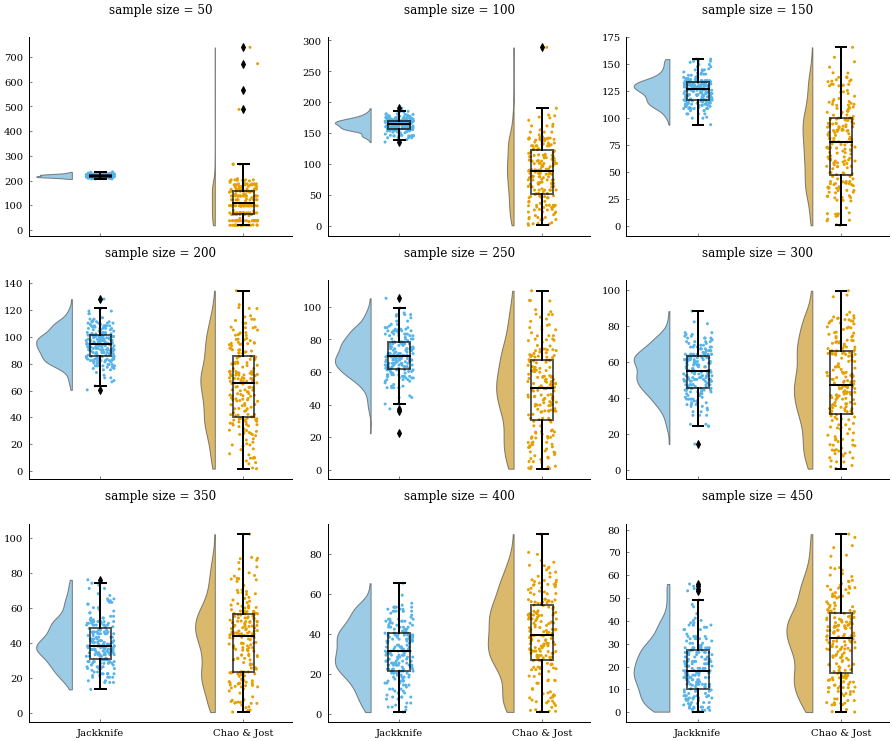

In [61]:
S_df = S_df.replace([np.inf, -np.inf], np.nan).dropna() 
S_df['RMSE'] = np.sqrt((s_pool - S_df['S']) ** 2)

with plt.rc_context({"text.usetex": False}):
    g = sns.FacetGrid(S_df, col="sample size", col_wrap=3, height=3.5, sharey=False, aspect=1.2)
    g = g.map_dataframe(pt.RainCloud, x="estimator", y="RMSE", data=S_df, palette=None,
                        orient="v", ax=g.axes, alpha=0.65, bw=.3, width_viol=0.5)

De eenvoudige Jackknife doet het zeker niet slecht voor grotere *sample sizes*. Deze cijfers laten zien dat Chao het beter doet in het geval van ondermonstering (*under-sampling*): met een geschatte verliesfactor van 8% bij de (niet-geïllustreerde) handschriften lijkt het erop dat we meer vertrouwen in de formula van Chao moeten plaatsen.

## Simulation 2

In [30]:
richnesses = range(150, 500, 150)
sample_sizes = range(100, 550, 50)
iterations, cv = 100, 0.937
results = []

for richness, sample_size in tqdm(list(product(richnesses, sample_sizes))):
    for i in range(iterations):
        pop = sample_lnorm(richness, n_sims=sample_size, cv=cv)
        estimate = np.mean(chao_estimate(pop)[-2]) # is dit juist? Bt value? Mean of median?
        #estimate = jackknife(pop)[0]
        results.append((sample_size, estimate, richness))
    
results = pd.DataFrame(results, columns=('sample_size', 'estimate', 'richness'))

100%|██████████| 27/27 [01:12<00:00,  2.68s/it]


In [31]:
results['RMSE'] = np.sqrt((results['richness'] - results['estimate']) ** 2)
results.head(10)

,sample_size,estimate,richness,RMSE
0,100,260.211429,150,110.211429
1,100,135.404231,150,14.595769
2,100,99.872857,150,50.127143
3,100,122.203438,150,27.796562
4,100,202.530000,150,52.530000
5,100,115.983077,150,34.016923
6,100,154.892500,150,4.892500
7,100,113.581522,150,36.418478
8,100,119.571429,150,30.428571
9,100,120.605000,150,29.395000


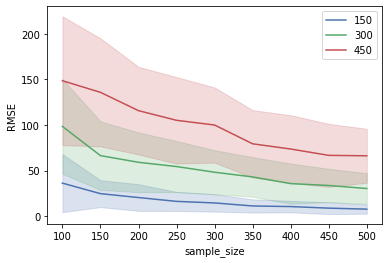

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

for idx, group in results.groupby('richness'):
    label = str(group['richness'].unique()[0])
    ax = sns.lineplot(x="sample_size", y="RMSE", ci= 'sd', data=group, label=label)
plt.legend();

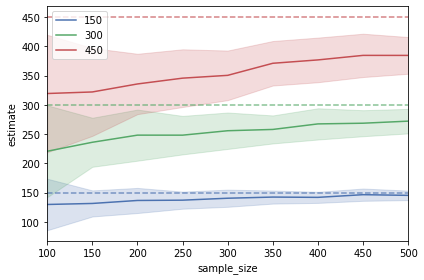

In [33]:
colors = sns.color_palette()[:3]

for (idx, group), c in zip(results.groupby('richness'), colors):
    label = str(group['richness'].unique()[0])
    ax = sns.lineplot(x="sample_size", y="estimate", ci= 'sd', data=group, label=label)
    plt.gca().axhline(int(label), c=c, ls='--', alpha=.7)
plt.legend()
plt.xlim((min(sample_sizes), max(sample_sizes)))
plt.tight_layout();

## Simulation 3

In [37]:
counts = np.bincount(mnl.groupby('text').size())[1:] # ignore zero
print(counts)

[42 13  6  3  3  1  1  0  0  2  0  0  0  0  0  1]


In [38]:
x = np.array(sum([[i]*c for i, c in enumerate(counts, 1)], []))
print(x)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  5  5  5  6  7 10 10 16]


Set a conservative growth or mutation rate:

In [39]:
bt_prob(num_per_text)[num_per_text[num_per_text == 1]].sum()

0.06106201312169907

In [40]:
prop_new = x[x==1].sum() / x.sum()
prop_new

0.25925925925925924

In [41]:
np.bin, rate, p=[1 - prop_new, prop_new])

SyntaxError: invalid syntax (<ipython-input-41-f12f61361d82>, line 1)

In [42]:
x[x==1].sum() / x.sum()

0.25925925925925924

In [43]:
np.random.seed(None)

growth_rates = range(1, 101)
iterations = 5000

estimates = []
x = np.array(sum([[i]*c for i, c in enumerate(counts, 1)], []))
prop_new = x[x==1].sum() / x.sum()

from tqdm import tqdm

for rate in tqdm(growth_rates):
    for it in range(iterations):
        new_pop = x.copy()
        mutations = np.random.binomial(1, prop_new, size=rate)
        species = np.arange(len(new_pop))
        probas = new_pop / new_pop.sum()
        idx = np.random.choice(species, size=(mutations==0).sum(), p=probas)
        new_pop[idx] += 1        
        if mutations.sum() > 0:
            new_pop = np.hstack((new_pop, [1] * mutations.sum()))
        
#         estimate = jackknife(new_pop)[0]
        estimate = chao_richness(new_pop)
        
        estimates.append((rate, it, estimate))

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [44]:
estimates = pd.DataFrame(estimates, columns=('rate', 'iteration', 'estimate'))

In [45]:
estimates.head()

,rate,iteration,estimate
0,1,0,139.429920
1,1,1,143.679094
2,1,2,139.429920
3,1,3,139.429920
4,1,4,143.679094


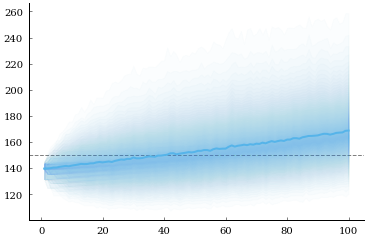

In [46]:
def tsplot(x, y, n=50, percentile_min=1, percentile_max=99, color="C0", plot_mean=True, plot_median=False, line_color="k", axis=0, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.nanpercentile(
        y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=axis
    )
    perc2 = np.nanpercentile(
        y, np.linspace(50, percentile_max, num=n + 1)[1:], axis=axis
    )

    if "alpha" in kwargs:
        alpha = kwargs.pop("alpha")
    else:
        alpha = 1 / n
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        ax.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)

    if plot_mean:
        ax.plot(x, np.nanmean(y, axis=axis), color=line_color)

    if plot_median:
        ax.plot(x, np.nanmedian(y, axis=axis), color=line_color)

    return ax

ests = pd.pivot_table(estimates, index='rate', columns='iteration', values='estimate')
ax = tsplot(growth_rates, ests.values.T, line_color="C0")
ax.axhline(150, ls='--', lw=1, c="gray", zorder=0)

[(100, 265)]

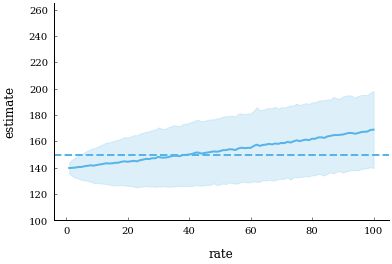

In [47]:
ax = sns.lineplot(x="rate", y="estimate", ci= 'sd', data=estimates)
ax.axhline(150, ls='--')
ax.set(ylim=(100, 265))

Laat ons twee assumpties maken:
- Er wordt ongeveer één nieuw fragment per jaar gevonden -- dat is een erg optimistische schatting.
- Een stijging van 10 handschriften is een "significante" stijging dit beeld -- we laten *p*-waarde's even buiten beschouwing want die zeggen weinig in deze context.

Dat leidt tot de volgende prognose: als de huidige *discovery speed* niet verandert, zou het minimaal een kwarteeuw (~30 jaar) kunnen duren voor we het beeld dat we in dit artikel schetsen betekenisvol zouden moeten bijstellen. In het beste geval zou het een eeuw duren om 50 nieuwe teksten te ontdekken.

In [51]:
import scipy.stats as stats
from scipy.special import gammaln

def bootstrap_re(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    Dq = fn(x)
    
    pro = np.array([fn(row) for row in data_bt])
    
    error = stats.norm.ppf(1 - (1 - conf) / 2) * np.std(pro, 0)
    lci_pro = Dq - error
    uci_pro = Dq + error

    sd_pro = np.std(pro, axis=0)

    return (lci_pro, uci_pro, sd_pro, Dq, )


def rarefaction_extrapolation(x, max_steps):
    x, n = x[x > 0], x.sum()
    def _sub(m):
        if m <= n:
            return np.sum(1 - np.array(
                [np.exp(gammaln(n - i + 1) + gammaln(n - m + 1) - 
                        gammaln(n - i - m + 1) - gammaln(n + 1)) if i <= (n - m) else
                 0 for i in x]))
        else:
            S = (x > 0).sum()
            f1, f2 = (x == 1).sum(), (x == 2).sum()
            f0 = ((n - 1) / n * f1 * (f1 - 1) / 2) if f2 == 0 else ((n - 1) / n * f1**2 / 2 / f2)
            A = n * f0 / (n * f0 + f1)
            return S if f1 == 0 else (S + f0 * (1 - A**(m - n)))
    return np.array([_sub(mi) for mi in range(1, max_steps)])

In [52]:
from functools import partial

lci_pro, uci_pro, sd_pro, Dq = bootstrap_re(x, fn=partial(rarefaction_extrapolation, max_steps=600), n_iter=50)

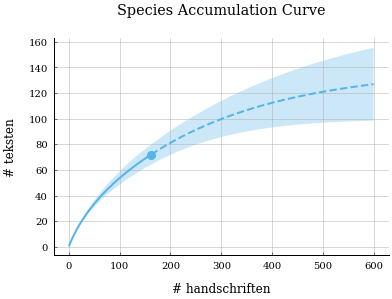

In [58]:
steps = np.arange(1, 600)
interpolated = np.arange(1, 600) < x.sum()
plt.plot(steps[interpolated], Dq[interpolated], color='C0')
plt.plot(x.sum(), Dq[x.sum() - 1], 'o')
plt.plot(steps[~interpolated], Dq[~interpolated], '--', color='C0')
plt.fill_between(steps, lci_pro, uci_pro, alpha=0.3)
plt.grid()
plt.xlabel('# handschriften')
plt.ylabel('# teksten')
plt.title('Species Accumulation Curve')
plt.savefig('accumulation.jpg')

In [59]:
162 / 600

0.27